# Age & Gender Detection with CNN

**Dataset : UTKFace**

UTKFace dataset is a large-scale face dataset with range from 0 to 116 years old. It consists of over 23,708 face images with labels of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc.

Since the dataset is `aligned and cropped` faces available to train the model. Have to say that any face input for testing must be cropped and aligned vertically to large extent.

In [2]:
# Essential libraries
import os
import glob
import seaborn as sns
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import applications,activations
from keras_preprocessing.image import img_to_array, load_img
from keras.preprocessing import image
from keras import optimizers,utils
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,ZeroPadding2D, Input
from keras.layers import Conv2D, Activation,MaxPooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [3]:
# Mounting the directory for the dataset to be read.
dataset_folder = '../ModelTrainingService/input/utkface-new/UTKFace/'
training_split = 0.7
image_width = image_height = 224

dataset_dict = {
    'age_id': {'0-24': 0, '25-49':1, '50-74':2, '75-99':3, '100-124':4},
    'race_id': {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
    'gender_id': {0: 'male', 1: 'female'}
}

dataset_dict['age_temp'] = dict((a, i) for i, a in dataset_dict['age_id'].items())          # (Age: id)
dataset_dict['gender_temp'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())    # (Gender: id)
dataset_dict['race_temp'] = dict((r, i) for i, r in dataset_dict['race_id'].items())        # (Race: id)

In [4]:
# Function to extract the data from our dataset by iterating over each file of the UTK dataset and
# return a Pandas Dataframe with all the fields (age, gender and sex).

def parse_dataset(dataset_path, ext='jpg'):

    def parse_info_from_file(path):  #Parsing info from a file

        try:
            file_name = os.path.split(path)[1]
            file_name = os.path.splitext(file_name)[0]
            age, gender, race, _ = file_name.split('_')

            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None

    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))

    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info) # To place new items in the available space

    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']


    df = df.dropna() # To remove the rows that contains NULL values.

    return df

In [5]:
# Dataset before indexing
df = parse_dataset(dataset_folder)
df.head()

,age,gender,race,file
0,100,male,white,../ModelTrainingService/input/utkface-new/UTKF...
1,100,male,white,../ModelTrainingService/input/utkface-new/UTKF...
2,100,female,white,../ModelTrainingService/input/utkface-new/UTKF...
3,100,female,white,../ModelTrainingService/input/utkface-new/UTKF...
4,100,female,white,../ModelTrainingService/input/utkface-new/UTKF...


In [6]:
# No NAN values, means our dataset is already clean.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     23708 non-null  int64 
 1   gender  23708 non-null  object
 2   race    23708 non-null  object
 3   file    23708 non-null  object
dtypes: int64(1), object(3)
memory usage: 741.0+ KB


In [7]:
# Lower percentile - 25, median - 50 & upper percentile - 75 (for numerical data)
df.describe()

,age
count,23708.000000
mean,33.303484
std,19.886112
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


In [8]:
# Mean age by gender
df.groupby(['gender']).mean('age')

,age
gender,
female,30.684280
male,35.695666


In [9]:
# Mean age by race
df.groupby(['race']).mean('age')

,age
race,
asian,25.877729
black,33.861498
indian,31.540241
others,23.169031
white,37.980949


# Data analysis & visualization (EDA)

We can create here a function to generate some pie plots. We also look at the other visualization below to understand and grasp better about the data distribution to crete
more efficient training, validation and test processes.

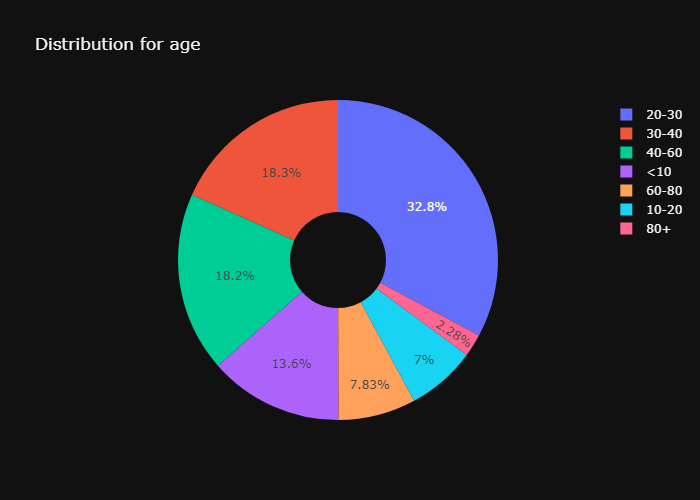

In [10]:
import plotly.graph_objects as go
from IPython.display import display, Image

def plot_distribution(pd_series):

    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()

    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)

    img_bytes = fig.to_image(format="png")
    #fig.show()
    display(Image(img_bytes))

# # Same as bar plot. Creating bins for age ranges and plotting that data. This helps us to see grouped age into bins with percentages.
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']
age_binned = pd.cut(df['age'], bins, labels=names)
plot_distribution(age_binned)

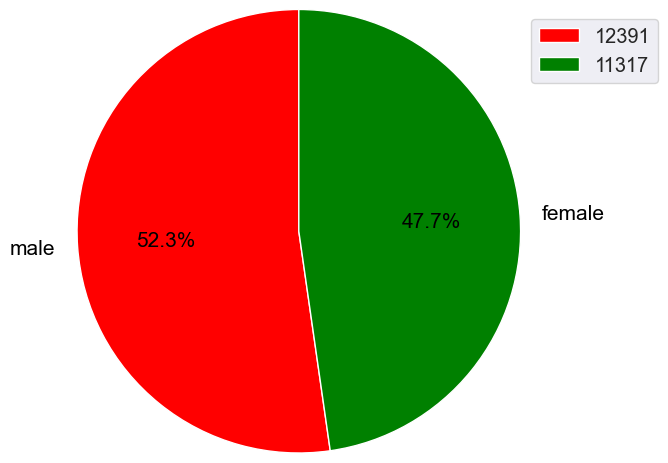

In [11]:
# Uniform distribution to a large extent. Although, males slightly exceed females in numbers.No need to change gender in data.
# Pretty well-balanced ! Let's also visualize this on a bar graph (to get better understanding of numbers)
x = (df.gender=='male').sum()
y = (df.gender=='female').sum()

# Males over 12k while females close to 12k
labels = ['male','female']
colors = [ 'r', 'g']
gender_pie = [x,y]
explode = (0, 0)  # explode the 2nd slice (i.e. 'female')
plt.pie(gender_pie,labels = labels,
        colors = colors,
        explode=explode,
        radius=1.5,
        autopct='%.1f%%',
        textprops={'color':"Black", 'size':15},
        startangle=90)
plt.legend(gender_pie, bbox_to_anchor=(1.1, 1.1), fontsize='x-large')
plt.show()

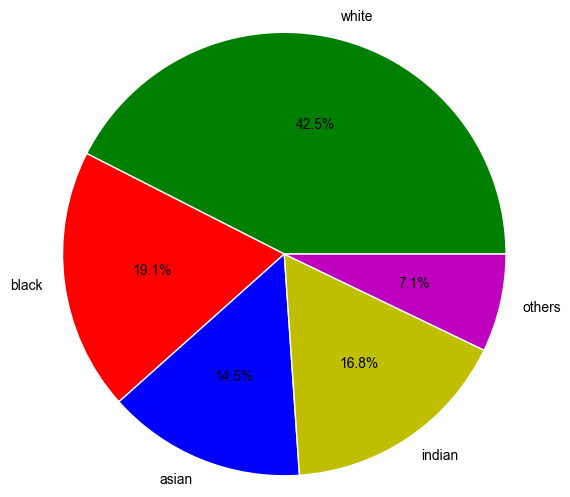

In [12]:
# Distribution for race
x = (df.race == 'white').sum()
y = (df.race == 'black').sum()
z = (df.race == 'asian').sum()
a = (df.race == 'indian').sum()
b = (df.race == 'others').sum()

race_pie = [x, y, z, a, b]
labels = ['white', 'black', 'asian', 'indian', 'others']
colors = ['g', 'r', 'b', 'y', 'm']
plt.pie(race_pie, labels=labels, colors=colors, radius=1.5, autopct='%.1f%%', textprops={'color':"Black", 'size':10},)
plt.show()

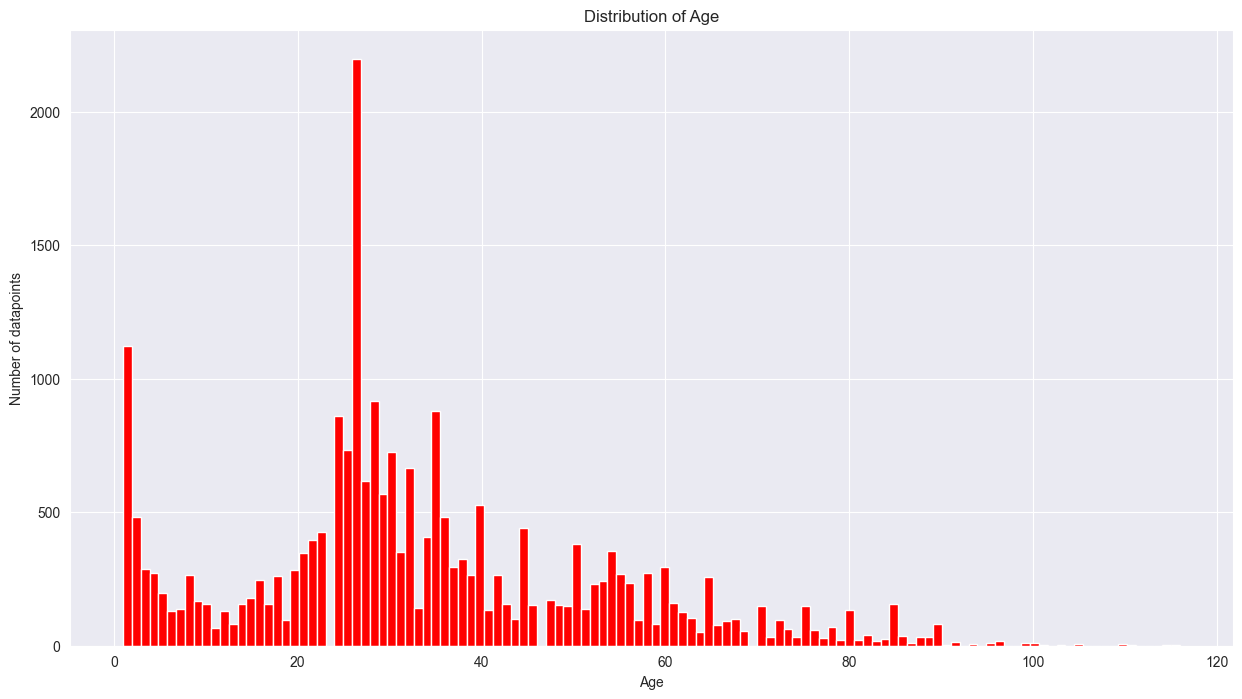

In [13]:
# The population is mostly between 20-30 age group, the dataset is not very well-balanced. We try to embrace this imbalance through imagedatagenerator below.
ages = df['age']
nbins = 120
plt.figure(figsize=(15,8))
plt.hist(ages,nbins,color='red',histtype='bar')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Number of datapoints')
plt.show()

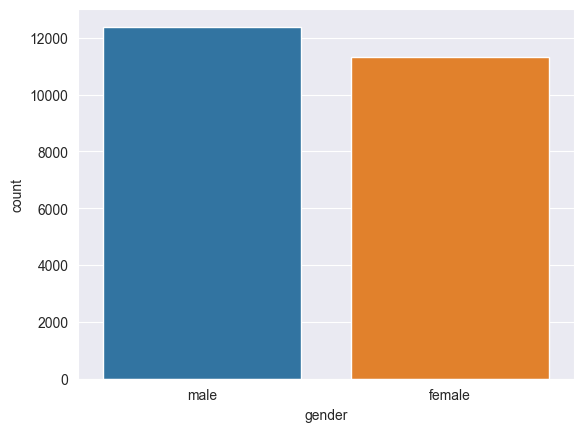

In [14]:
# Males over 12k & females close to 12k
sns.countplot(x='gender', data=df);

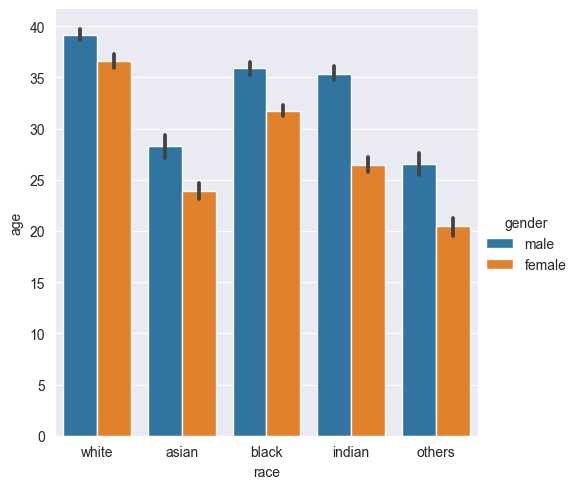

In [15]:
# Gives the mean age of both genders of all races
sns.catplot(x='race', y='age', hue='gender', data=df,kind='bar', height=5);

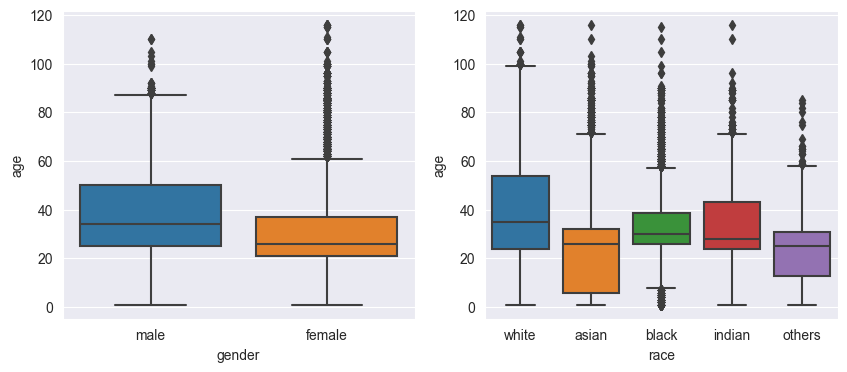

In [16]:
# We see that most of the males are between 25 and 55, whereas most of the females are between 20 and 40.
# Grouping by race, there is good amount of variations in different races.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

In [17]:
# RUN THIS CELL ONLY ONCE
# To create age groups
df['age'] = df['age']//25

''' This basically makes 5 divisions in age-groups -
1. 0-24
2. 25-49
3. 50-74
4. 75-99
5. 100-124 '''

x = (df.age==0).sum()
y = (df.age==1).sum()
z = (df.age==2).sum()
a = (df.age==3).sum()
b = (df.age==4).sum()
c = (df.age==5).sum() # To see that nothing left in the dataset

print(x,' ', y,' ', z,' ', a,' ', b, ' ', c,' ')

6903   11816   3990   967   32   0  


In [18]:
# After distribition of the ages into groups, we have now age groups 0 to 4 for age feature which contains ages from 1y to 116y.
df.head()

,age,gender,race,file
0,4,male,white,../ModelTrainingService/input/utkface-new/UTKF...
1,4,male,white,../ModelTrainingService/input/utkface-new/UTKF...
2,4,female,white,../ModelTrainingService/input/utkface-new/UTKF...
3,4,female,white,../ModelTrainingService/input/utkface-new/UTKF...
4,4,female,white,../ModelTrainingService/input/utkface-new/UTKF...


# Data image generator
To be able to use as input to our model, below is the keras image data generator by creating batches of image data to feed the multi-output predictions.

In [25]:
# Data image generator for augmenting the data
# Generating batches of data, which will be used to feed our multi-output model with both the images and their labels.
import cv2
from keras.utils import to_categorical, normalize
from PIL import Image, ImageFont

class UtkFaceDataGenerator():

    # Data generator for the UTKFace dataset. This class should be used when training our Keras multi-output model.
    def __init__(self, df):
        self.df = df

    def generate_split_indexes(self):
      p = np.random.permutation(len(self.df))
      train_df = int(len(self.df) * training_split)
      train_idx = p[:train_df]
      test_idx = p[train_df:]

      train_df = int(train_df * training_split)
      train_idx, valid_idx = train_idx[:train_df], train_idx[train_df:]


      # converts alias to id
      self.df['age_id'] = self.df['age'].map(lambda age: dataset_dict['age_temp'][age])
      self.df['gender_id'] = self.df['gender'].map(lambda gender: dataset_dict['gender_temp'][gender])
      self.df['race_id'] = self.df['race'].map(lambda race: dataset_dict['race_temp'][race])
      #self.max_age = self.df['age'].max()

      return train_idx, valid_idx, test_idx

    def preprocess_image(self, img_path):

      # Used to perform some minor preprocessing (BGR2RGB) on the image before inputting into the network because matplotlib plot function expects RGB.

      im = cv2.imread(img_path)
      im = cv2.resize(im, (image_width, image_height))
      im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
      im = np.array(im) / 255.0

      return im

    def generate_images(self, image_idx, is_training, batch_size=16):
      """
      Used to generate a batch with images when training/testing/validating our Keras model.
      """

      # arrays to store our batched data
      images, ages, races, genders = [], [], [], []
      while True:
        for idx in image_idx:
          person = self.df.iloc[idx]

          age = person['age']
          race = person['race_id']
          gender = person['gender_id']
          file = person['file']

          im = self.preprocess_image(file)

          #ages.append(age / self.max_age)
          ages.append(to_categorical(age,len(dataset_dict['age_id'])))
          races.append(to_categorical(race, len(dataset_dict['race_id'])))
          genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
          images.append(im)

          # yielding condition
          if len(images) >= batch_size:
            yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
            images, ages, races, genders = [], [], [], []

        if not is_training:
          break

data_generator = UtkFaceDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()

print('Train dataset lenght: ', len(train_idx))
print('Validation dataset lenght: ', len(valid_idx))
print('Test dataset lenght: ', len(test_idx))


Train dataset lenght:  11616
Validation dataset lenght:  4979
Test dataset lenght:  7113


NameError: name 'preprocess_image' is not defined

## Model Architecture

In [ ]:
# Source: https://pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/
# CNN Model Architecture by splitting the labels (age, gender, race) for flatten, dropout and activation of the layers.
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers import SpatialDropout2D
from keras.layers import Flatten
from keras.layers import Input
from keras.regularizers import l2
import tensorflow as tf

# SeparableConv2D: A variation of the traditional convolution that was to compute it faster than conv2D.
# "same" vs "valid": Output size is the "same" results in padding with zeros evenly to the left/right or up/down, while "valid" is no padding.
# Source for more detail about padding: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t
# BatchNormalization: To speed up training and to use higher learning rates, making learning easier and to distribute the data uniformly across a mean
#                     that the network sees best as well as to guarantee that the values are within a healthy range, avoiding saturation and vanishing gradients.
# MaxPooling2D: To downsample the input along its spatial dimensions (height and width) by taking the maximum value over an input window defined by pool_size for each channel.
# SpatialDropout2D: To drop the entire 2D feature maps instead of individual elements as dropout does.
# Strides: The window for shifting.
# Source: https://stackoverflow.com/questions/59634780/correct-order-for-spatialdropout2d-batchnormalization-and-activation-function
# Dropouts: To prevent over-fitting the model during training
# relu(Rectifier Linear Unit): Activation to prevent exponential growth in the computation and the emergence of the “vanishing gradient” problem
#                               by keeping gradient always high.
# Dense layer: To create fully connected layers, in which (linear) every output depends on every input after usage of Convolutional Layers with fewer parameters
# by forcing every input to the function and let the neurol network to learn its relation to the output.


class UtkMultiOutputModel():
    """
    Used to generate our multi-output model. This CNN contains three branches, one for age, other for
    sex and another for race. Each branch contains a sequence of Convolutional Layers that is defined
    on the make_default_hidden_layers method.
    """

    def hidden_layers(self, inputs):

        # To generate a default set of hidden layers. Structured as => Conv2D -> Activation "relu" -> BatchNormalization -> Pooling -> Dropout

        x = SeparableConv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = SpatialDropout2D(0.25)(x)

        x = SeparableConv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = SpatialDropout2D(0.25)(x)

        x = SeparableConv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = SpatialDropout2D(0.25)(x)

        x = SeparableConv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = SpatialDropout2D(0.25)(x)

        return x

    def build_race_branch(self, inputs):

        # Race branch is structured as => Conv -> BatchNormalization -> Pool -> Dropout blocks, followed by the Dense output layer.
        x = self.hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(64)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(5)(x)
        x = Activation("softmax", name="race")(x)

        return x

    def build_gender_branch(self, inputs):

        # The gender branch is structured as = Conv -> BatchNormalization -> Pool -> Dropout blocks, followed by the Dense output layer.
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)
        x = self.hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(2)(x)
        x = Activation("softmax", name="gender")(x)

        return x

    def build_age_branch(self, inputs):

        # The age branch is structured as = Conv -> BatchNormalization -> Pool -> Dropout blocks, followed by the Dense output layer.
        x = self.hidden_layers(inputs)
        x = Flatten()(x)
        x = Dense(64)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(5)(x)
        x = Activation("softmax", name="age")(x)

        return x

    # To assemble the output model with their determined height and width.
    def assemble_full_model(self, width, height):

        input_shape = (height, width, 3)
        inputs = Input(shape=input_shape)

        age_branch = self.build_age_branch(inputs)
        race_branch = self.build_race_branch(inputs)
        gender_branch = self.build_gender_branch(inputs)
        model = Model(inputs=inputs,
                     outputs = [age_branch, race_branch, gender_branch],
                     name="face_net")
        return model

model = UtkMultiOutputModel().assemble_full_model(image_width, image_height)

# To print out and save the layer model plot as png
from keras.utils import plot_model

plot_model(model, to_file='../ModelTrainingService/cnn_model_plot(latest).png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

## Training the model


In [ ]:
from keras.metrics import AUC
import math
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler

# Source: https://neptune.ai/blog/keras-metrics
init_lr = 1e-4
epochs = 80
#opt = Adam(learning_rate=0.0)                   # 0.0 means not to be used here.
opt = Adam(learning_rate=init_lr, decay=init_lr / epochs)
model.compile(optimizer=opt,
              loss={
                  'age': 'categorical_crossentropy',
                  'race': 'categorical_crossentropy',
                  'gender': 'categorical_crossentropy'},
              loss_weights={
                  'age': 1.,
                  'race': 1.5,
                  'gender': 0.1},
              metrics={
                  'age': ['accuracy', AUC(curve="ROC")],
                  'race': ['accuracy', AUC(curve="ROC")],
                  'gender': ['accuracy', AUC(curve="ROC")]})

In [ ]:
# class_weight in Keras: To ensure the unevenness in data distribution (as in age) is sorted out by giving the classes with fewer numbers is assigned more
# weight to prevent being biased.
from sklearn.utils import class_weight

class_weight = class_weight.compute_class_weight('balanced',
                                                 classes=np.array([0,1,2,3,4]),
                                                 y=np.array(df['age']))

class_weight1 = {'age': class_weight}

In [ ]:
# To generate batches for train_idx to be able to prevent "too large to fit inside RAM at once so-called memory errors".
# Soource: https://www.codementor.io/@alexander-k/keras-training-earlystopping-callback-to-avoid-overfitting-1ehrjlx8kw

import sys
import math
import keras
from datetime import datetime
import datetime
import time
import os
from django.utils.datetime_safe import datetime
from keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras
plt.style.use('ggplot')
from sklearn.preprocessing import LabelBinarizer
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

# CALLBACKS

# Exponential_decay() or step_decay() functions alternatively can be used for dynamic learning rate
#----------------------------------------------------------------------------------------------------------------------------------------------
# Learning Rate Schedules in Keras reduces the learning rate by a certain factor after certain no of epochs

#Source:    (https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)
#           (https://sanjayasubedi.com.np/deeplearning/multioutput-keras/)
#           (https://github.com/sukilau/Ziff-deep-learning/blob/master/3-CIFAR10-lrate/CIFAR10-lrate.ipynb)

# According ot several sources (few example of it above), since the learning rate is the most important
# hyperparameter to tune the training in a neural network, it is stated that to reduce learning rate as the training progresses,
# is a good practice for a better outcome (accuracy).

# Exponential Decay
# def exp_decay(epoch):
#    initial_lrate = 0.001
#    k = 0.2
#    lrate = initial_lrate * np.exp(-k * epoch)  # lr, k are hyperparameters and t=epoch is the iteration number
#    return lrate

# Step Decay, to drop the learning rate by a factor every few epochs.
# def step_decay(epoch):
# 	initial_lrate = 0.008
# 	drop = 0.7              # % drop rate
# 	epochs_drop = 5.0       # To drop after every number of epoch
# 	lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop)) #Fromula for step_decay
# 	return lrate

# Source: (https://datascience.stackexchange.com/questions/42599/what-is-the-relationship-between-the-accuracy-and-the-loss-in-deep-learning)
# a low accuracy and huge loss means you made huge errors on a lot of data
# a low accuracy but low loss means you made little errors on a lot of data
# a great accuracy with low loss means you made low errors on a few data (best case)

# lrate = LearningRateScheduler(step_decay)       # At the beginning of every epoch, this callback gets the updated learning rate value
#lrate = LearningRateScheduler(exp_decay)

# `binary_crossentropy`, sigmoid activation, scalar target.
# `categorical_crossentropy`, softmax activation, one-hot encoded target.

# It is this callback that allows a function to invoke during program execution.
#callbacks_list = [lrate]
#----------------------------------------------------------------------------------------------------------------------------------------

# To measure the time for the traiing session
start = datetime.now()

filepath = "../ModelTrainingService/models/CNN_Dec260151.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

monitor_val_acc = [EarlyStopping(monitor = 'val_loss',
                                min_delta = 0,
                                patience = 10,
                                verbose = 1,
                                mode='max',
                                restore_best_weights = True)]

#callbacks_list = [PlotLossesKeras(), monitor_val_acc, checkpoint]


# Training and validation batches
batch_size = 32
train_gen = data_generator.generate_images(train_idx,
                                           is_training=True,
                                           batch_size=batch_size)

valid_gen = data_generator.generate_images(valid_idx,
                                           is_training=True,
                                           batch_size=batch_size)

# fit() as known fit_generator() before 2020: Validation while training the model to evaluate the loss.
history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    #callbacks=callbacks_list,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//batch_size,
                    verbose=1)

#Training time
end = datetime.now()
elapsed = end-start
print ('\nElapsed Time: ', elapsed)

In [ ]:
# save the model to disk
#Source: (https://www.tensorflow.org/api_docs/python/tf/keras/models/save_model)
# Save the entire model as a SavedModel.

# save(): To create a SavedModel folder `saved_model`, containing "assets", "saved_model.pb" & "variables".
# The model architecture, and training configuration (including the optimizer, losses, and metrics) are stored in `saved_model.pb`.
# The weights are saved in the `variables/` directory.
# path = "../models/saved_model/latest_model"

#model.save('../models/saved_model/latest_model/you_model_name.tf')

f_name = r'CNN-model-'
f_time = datetime.now().strftime("%Y-%m-%d_%I-%M-%S_%p")
file = f_name + f_time + '.h5'
filepath = '../ModelTrainingService/models/' + file
model.save(filepath, include_optimizer=True)
print("[INFO] Model \"%s\" saved (Saving into the path takes few minutes)." % file)

In [ ]:
def func(a, b):
    return a + b

In [ ]:
def foo(x):
  return 1 + 1

In [ ]:
import nbformat as nbf
from glob import glob

# Collect a list of all notebooks in the content folder
notebooks = glob("./**/*.ipynb", recursive=True)

# Text to look for in adding tags
text_search_dict = {
    "# HIDDEN": "remove-cell",  # Remove the whole cell
    "# NO CODE": "remove-input",  # Remove only the input
    "# HIDE CODE": "hide-input"  # Hide the input w/ a button to show
}

# Search through each notebook and look for the text, add a tag if necessary
for ipath in notebooks:
    ntbk = nbf.read(ipath, nbf.NO_CONVERT)

    for cell in ntbk.cells:
        cell_tags = cell.get('metadata', {}).get('tags', [])
        for key, val in text_search_dict.items():
            if key in cell['source']:
                if val not in cell_tags:
                    cell_tags.append(val)
        if len(cell_tags) > 0:
            cell['metadata']['tags'] = cell_tags

    nbf.write(ntbk, ipath)

In [ ]:
# Load the latest trained model
from keras.models import load_model

#loaded_model = load_model('../models/saved_model/latest_model')
#loaded_model = load_model('../models/saved_model/latest_model/you_model_name.tf')
loaded_model = load_model(filepath, compile=False)
print("[INFO] Model \"%s\" loaded" % file)

In [ ]:
# Predict the age group and the gender of the person from aligned & cropped profile face picture.

from keras.preprocessing import image
from keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator

# Load the image and size it.
def loadImage(filepath):
  test_img = load_img(filepath, target_size=(image_width, image_height, 3))
  test_img = img_to_array(test_img)
  test_img /= 255
  test_img = np.expand_dims(test_img, axis = 0)

  return test_img

import random as rn
from PIL import Image, ImageFont

# To choose image randomly from dataset
path=df['file']
picture = rn.choice(path)

#picture='../models/test_img/kenny-rogers.jpg' # Change the path for other image files if you would like to see more.
age_prediction, race_prediction, gender_prediction = loaded_model.predict(loadImage(picture))

print('Age_prediction: ', (age_prediction * 100), '%')
print('Race_prediction: ', (race_prediction * 100), '%')
print('Gender_prediction: ', (gender_prediction * 100), '%')
print(picture)

img = load_img(picture)
plt.imshow(img)
plt.show()
max = -1
count = 0

for i in age_prediction[0]:
    if i > max:
        max = i
        temp = count
    count+=1

#Conditions for outputs
if temp == 0:
    print('0-24 yrs old')
if temp == 1:
    print('25-49 yrs old')
if temp == 2:
    print('50-74 yrs old')
if temp == 3:
    print('75-99 yrs old')
if temp == 4:
    print('100-124 yrs old')

if gender_prediction[0][0] > gender_prediction[0][1]:
  print('Male')
else:
  print('Female')

## Evaluating our model on the validation and test dataset

In [ ]:
# To returns the loss value & metric values for the model in test dataset
test_batch_size = 64
test_generator = data_generator.generate_images(test_idx,
                                                is_training=False,
                                                batch_size=test_batch_size)

age_pred, race_pred, gender_pred = model.predict(test_generator,
                                                 steps=len(test_idx)//test_batch_size)
# print('Age_on_test: ', len(age_pred))
# print('Gender_on_test: ', len(gender_pred))
# print('Race_on_test: ', len(race_pred))

In [ ]:
test_batch_size = 128

test_generator  = data_generator.generate_images(test_idx,
                                                is_training=False,
                                                batch_size=test_batch_size)

images, age_true, race_true, gender_true = [], [], [], []

for test_batch in test_generator:
    image = test_batch[0]
    labels = test_batch[1]

    images.extend(image)
    age_true.extend(labels[0])
    race_true.extend(labels[1])
    gender_true.extend(labels[2])

age_true = np.array(age_true)
race_true = np.array(race_true)
gender_true = np.array(gender_true)

race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)

age_true = age_true.argmax(axis=-1) # * data_generator.max_age
age_pred = age_pred.argmax(axis=-1) # * data_generator.max_age

In [ ]:
# Evaluate the model on test data
test_gen = data_generator.generate_images(test_idx,
                                           is_training=True,
                                           batch_size=32)

test_results = {}
test_scores = model.evaluate(test_gen, steps=4742, verbose=1, batch_size=32)
print('\nEvaluation results on test dataset...')
dict(zip(model.metrics_names, test_scores))
# test_results = dict(zip(model.metrics_names, val_scores))
# print('\n')
# for key, value in test_results.items():
#   print("%s: %s" % (key, round(value*100, 2)), '%')

In [ ]:
# Classification report for gender feature
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report for "Age"\n')
classification_report_gender = classification_report(gender_true, gender_pred, target_names=dataset_dict['gender_temp'].keys())
print(classification_report_gender)

In [ ]:
# Classification report for age feature
classification_report_gender = classification_report(age_true, age_pred, target_names=dataset_dict['age_id'].keys(), zero_division=0)
print(classification_report_gender)
#print('Classification Report for "Gender"\n')

In [ ]:
# Age ROC curves (Multiclass classification)
# Source: https://stackoverflow.com/questions/39685740/calculate-sklearn-roc-auc-score-for-multi-class
from sklearn.metrics import accuracy_score, roc_curve

age_groups = ['0-24', '25-49','50-74','75-99', '100-124']
def roc_auc_score_multiclass(age_true, age_pred, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(age_true)
  roc_auc_dict = {}

  for per_class in unique_class:
    #creating a list of all the classes except the current class
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in age_true]
    new_pred_class = [0 if x in other_class else 1 for x in age_pred]

    #using the sklearn metrics method to calculate the roc_auc_score
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr_age, tpr_age, threshold_age = roc_curve(new_actual_class, new_pred_class)
    roc_auc = roc_auc_score(new_actual_class, new_pred_class)
    roc_auc_dict[per_class] = roc_auc


    # plotting
    plt.plot(fpr_age, tpr_age, linestyle='-',color='red', label=f'Area Under ROC Curve : {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
    plt.title('Age group ' + age_groups[per_class] + ' ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best', fancybox=True,)
    save_name = 'metrics_figures/ROC_curve_age_group_' + age_groups[per_class] + '.png'
    plt.savefig(save_name, bbox_inches='tight')
    plt.show()
    plt.close()

  return roc_auc_dict

roc_auc_multiclass = roc_auc_score_multiclass(age_true, age_pred)
acc = accuracy_score(age_true, age_pred)

for i in roc_auc_multiclass:
  print('Roc_Auc_score for age group', age_groups[i], ': {:.0%}'.format(roc_auc_multiclass[i]))

In [ ]:
# Gender ROC curves (Binary classification)
from sklearn.metrics import roc_auc_score, roc_curve

fpr_gender, tpr_gender, threshold_gender = roc_curve(gender_true, gender_pred)
auc_score_gender = roc_auc_score(gender_true, gender_pred)

# plotting
plt.plot(fpr_gender, tpr_gender, linestyle='-',color='green', label=f'Area Under ROC Curve : {auc_score_gender:.3f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Gender ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best', fancybox=True,)
plt.savefig(fname='metrics_figures/ROC_curve_gender.png', bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Confusion matrix for age and gender (true vs predicted)
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools

# Source= https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm,
               interpolation='nearest',
               cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if title == 'Confusion Matrix for "Age" (Multiclass Classification)':
      plt.savefig(fname='metrics_figures/Conf_Mtrx_age.png', bbox_inches='tight')
    else:
      plt.savefig(fname='metrics_figures/Conf_Mtrx_gender.png', bbox_inches='tight')
    plt.show()
    plt.close()

print('Total age count in test dataset: %s' % len(age_pred), '\n')
cm_age = confusion_matrix(age_true, age_pred)
cm_age_plot_labels = ['0-24', '25-49', '50-74', '75-99', '100-124']
plot_confusion_matrix(cm=cm_age, classes=cm_age_plot_labels, title='Confusion Matrix for "Age" (Multiclass Classification)')

print('Total gender count in test dataset: %s' % len(gender_pred), '\n')
cm_gender = confusion_matrix(gender_true, gender_pred)
cm_gender_plot_labels = ['male', 'female']
plot_confusion_matrix(cm=cm_gender, classes=cm_gender_plot_labels, title='Confusion Matrix for "Gender" (Binary Classification)')

In [ ]:
# Age accuracy
plt.plot(history.history['age_accuracy'])
plt.plot(history.history['val_age_accuracy'])
plt.title('Age Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best', fancybox=True)
plt.savefig(fname='metrics_figures/accuracy_age.png', bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Gender accuracy
plt.plot(history.history['gender_accuracy'])
plt.plot(history.history['val_gender_accuracy'])
plt.title('Gender Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best', fancybox=True)
plt.savefig(fname='metrics_figures/accuracy_gender.png', bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Overall loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Overall Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best', fancybox=True)
plt.savefig(fname='metrics_figures/overall_loss.png', bbox_inches='tight')
plt.show()
plt.close()